In [10]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import time
import pickle

from functools import reduce

%matplotlib inline
import matplotlib.pyplot as plt

Считываем вход из файлов и преобразуем в DataFrame. Кроме того, если необходимо выполнить преобразование входа, можно передать соответствующую трансформирующую функцию *map_f*

In [3]:
INPUT_PATH = './input/'

storage = {}

def read_base(N, map_f=None):
    global storage
    dataset = storage.get(N)
    c_type = 'mapped' if map_f else 'raw'
    if dataset:
        if dataset.get(c_type):
            print ('found cached data...')
            return dataset[c_type]
    else:
        storage[N] = dict()
    print ('reading data from source...')
    LINES = 10**6
    path = '{}Base{}.txt'.format(INPUT_PATH, N)
    X, y = [], []
    with open(path, 'r') as fin:
        for l in tqdm(fin.readlines()):
            x = l.split()[0]
            if map_f:
                X.append(map_f(x))
            else:
                X.append(list(x))
            y.append(l.split()[1])
    print ('converting to dataframe...')
    storage[N][c_type] = (pd.DataFrame(X, dtype=int), pd.Series(y, dtype=int))
    return storage[N][c_type]

Убедимся, что данные выглядят так, как надо:

In [4]:
X, y = read_base(8)
print (X.shape, y.shape)
print (X[:5])
print (y[:5])

  0%|          | 0/1000000 [00:00<?, ?it/s]

reading data from source...


100%|██████████| 1000000/1000000 [00:02<00:00, 460483.11it/s]


converting to dataframe...
(1000000, 8) (1000000,)
   0  1  2  3  4  5  6  7
0  1  0  0  0  1  0  0  1
1  0  0  1  0  1  0  1  1
2  1  1  1  1  1  0  1  1
3  1  0  1  0  1  0  1  1
4  1  0  1  1  0  0  0  0
0    0
1    0
2    1
3    1
4    1
dtype: int64


Определим функцию обучения для определенного классификатора. Предпочтение в разделение исходной выборки на train/test был отдан методу *train_test_split*, поскольку  *KFold* не имеет смысла, поскольку, например для *LogisticRegression*:

```warm_start : bool, default: False
When set to True, reuse the solution of the previous call to fit as initialization, otherwise, just erase the previous solution. Useless for liblinear solver.```

Кроме того, будем выводить **confusion_matrix** для каждого результата обучения, а также метрику **accuracy** (*model.score*)

In [5]:
def learn(X, y, model):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    score = model.score(X_test, y_test)
    print (score)
    return model, score

Здесь выполним трансформирующую функцию для входа. Помимо считанных значений из файла, попробуем добавить в качестве характеристик следующие параметры: посчитаем для каждого *i* переключателя характер распространения сигнала на нем, а именно, поменялись ли в итоге каналами сигналы или нет. Другими словами, если количество *1* четно до *i* блока, то сигналы идут по тем же каналам, как и были запущены из истока, иначе нет. Это достигается поэлементным ксором переключателей. Точно так же сделаем и для блоков, начиная с выхода (в обратном направлении)

In [12]:
def try_map(x):
    all_xor = reduce(lambda kum, v: kum ^ int(v), x, 0)
    res = []
#     res.append(all_xor)
    cur_xor = all_xor
    for i in x:
        cur_xor ^= int(i)
        res.append(cur_xor)
    cur_xor = 0
    for i in x:
        cur_xor ^= int(i)
        res.append(cur_xor)
    return res

Проверим работоспособность с логистической регрессией на небольшом входе:

Определим функцию для сравнения результатов обучения без применения т.н. "feature engineering" и вместе с ним:

In [13]:
def try_both(N, model):
    X, y = read_base(N)
    learn(X, y, model)
    
    X, y = read_base(N, try_map)
    learn(X, y, model)

Выполним обучение для всех возможных *BaseN* с выбранной моделью, параллельно насчитывая время, затраченное на чтение/обучение:

In [14]:
def check_all_N(model, N_from=8, N_to=130):
    scores = []
    Ns = range(N_from, N_to, 8)
    
    def run(N):
        print ('running with map for N={}'.format(N))
        X, y = read_base(N, try_map)
        learned, score = learn(X, y, model)
        filename = 'output/pickled_{}.pkl'.format(N)
        with open(filename, 'wb') as fout:
            pickle.dump(learned, fout)
        return learned, score
    
    for N in Ns:
        st = time.clock()
        scores.append(run(N))
        print (time.clock() - st, 's')

    plt.figure(figsize=(16, 7))
    plt.plot(Ns, scores)
    plt.title('Score')
    plt.xlabel('N')
    plt.ylabel('Score')
    plt.show()

Запустим логистическую регрессию:

In [15]:
model = LogisticRegression(n_jobs=-1, random_state=6)
check_all_N(model)

running with map for N=8
found cached data...


/Users/chiselko6/anaconda/envs/iai/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


1.0
6.129373999999984 s
running with map for N=16
found cached data...
0.996845
17.976774999999975 s
running with map for N=24
found cached data...
0.995075
19.729752000000076 s
running with map for N=32
found cached data...
0.99444
23.343706999999995 s
running with map for N=40
found cached data...
0.994225
30.058357 s
running with map for N=48
found cached data...
0.99413
41.53965100000005 s
running with map for N=56
reading data from source...



 20%|█▉        | 198290/1000000 [00:17<00:52, 15277.09it/s]


 40%|████      | 401138/1000000 [00:31<00:39, 15008.57it/s]


 62%|██████▏   | 619564/1000000 [00:45<00:22, 16598.85it/s]


 83%|████████▎ | 830330/1000000 [01:00<00:11, 15074.51it/s]


100%|██████████| 1000000/1000000 [01:11<00:00, 14080.94it/s]

converting to dataframe...
0.99385
136.513686 s
running with map for N=64
reading data from source...



 16%|█▌        | 156788/1000000 [00:18<01:40, 8394.18it/s]


 31%|███       | 311636/1000000 [00:33<01:18, 8722.16it/s]


 49%|████▉     | 487507/1000000 [00:47<00:35, 14632.09it/s]


 68%|██████▊   | 676598/1000000 [01:02<00:24, 12979.06it/s]


 86%|████████▌ | 856435/1000000 [01:18<00:09, 14407.15it/s]


100%|██████████| 1000000/1000000 [01:28<00:00, 11256.16it/s]

converting to dataframe...
0.993855
163.1221569999999 s
running with map for N=72
reading data from source...



 17%|█▋        | 172986/1000000 [00:16<01:00, 13605.81it/s]


 34%|███▍      | 341066/1000000 [00:30<00:50, 13066.35it/s]


 51%|█████     | 508508/1000000 [00:45<00:36, 13286.82it/s]


 68%|██████▊   | 676722/1000000 [00:59<00:28, 11191.16it/s]


 83%|████████▎ | 834086/1000000 [01:14<00:20, 7991.95it/s]


 98%|█████████▊| 983319/1000000 [01:33<00:02, 7269.46it/s]


100%|██████████| 1000000/1000000 [01:34<00:00, 10557.96it/s]

converting to dataframe...
0.993405
184.98003799999992 s
running with map for N=80
reading data from source...



 16%|█▌        | 158209/1000000 [00:13<01:11, 11812.03it/s]


 31%|███▏      | 314165/1000000 [00:29<00:59, 11620.59it/s]


 47%|████▋     | 468830/1000000 [00:44<00:44, 11944.43it/s]


 62%|██████▏   | 621369/1000000 [00:57<00:35, 10797.87it/s]


 77%|███████▋  | 771458/1000000 [01:13<00:20, 10915.79it/s]


 93%|█████████▎| 927994/1000000 [01:29<00:27, 2648.22it/s]


100%|██████████| 1000000/1000000 [01:35<00:00, 10423.01it/s]

converting to dataframe...
0.993455
189.11719199999993 s
running with map for N=88
reading data from source...



 14%|█▍        | 140849/1000000 [00:13<01:18, 10947.38it/s]


 28%|██▊       | 277238/1000000 [00:30<14:05, 855.09it/s]  


 39%|███▉      | 390891/1000000 [00:46<02:06, 4802.25it/s]


 40%|███▉      | 399779/1000000 [00:47<01:14, 8044.26it/s]

KeyboardInterrupt: 


 40%|███▉      | 399779/1000000 [01:00<01:14, 8044.26it/s]

Запустим KNN:

In [ ]:
model = KNeighborsClassifier(n_jobs=-1, n_neighbors=32)
X, y = read_base(16, try_map)
learn(X, y, model)

found cached data...


Попробуем сходимость SVM классификатора на небольшом входе:

In [10]:
model = LinearSVC(max_iter=10000, random_state=6, verbose=5)
try_both(16, model)

  0%|          | 0/1000000 [00:00<?, ?it/s]

reading data from source...


100%|██████████| 1000000/1000000 [00:03<00:00, 295846.77it/s]


converting to dataframe...
[LibLinear]
[[59675 36804]
 [40623 62898]]
0.612865
found cached data...
[LibLinear]
[[ 96247    232]
 [   367 103154]]
0.997005


И запустим его для больших *BaseN* ($N >= 96$), чтобы сэкономить время:

running with map for N=96
found cached data...
[LibLinear]
[[99634   747]
 [  830 98789]]
0.992115
154.833477
running with map for N=104
found cached data...
[LibLinear]
[[ 85786    794]
 [   786 112634]]
0.9921
175.556763
running with map for N=112
found cached data...
[LibLinear]
[[ 93427    797]
 [   822 104954]]
0.991905
194.103527
running with map for N=120
found cached data...
[LibLinear]
[[ 93016    761]
 [   848 105375]]
0.991955
203.891302
running with map for N=128
found cached data...
[LibLinear]
[[ 75946    834]
 [   818 122402]]
0.99174
237.141778


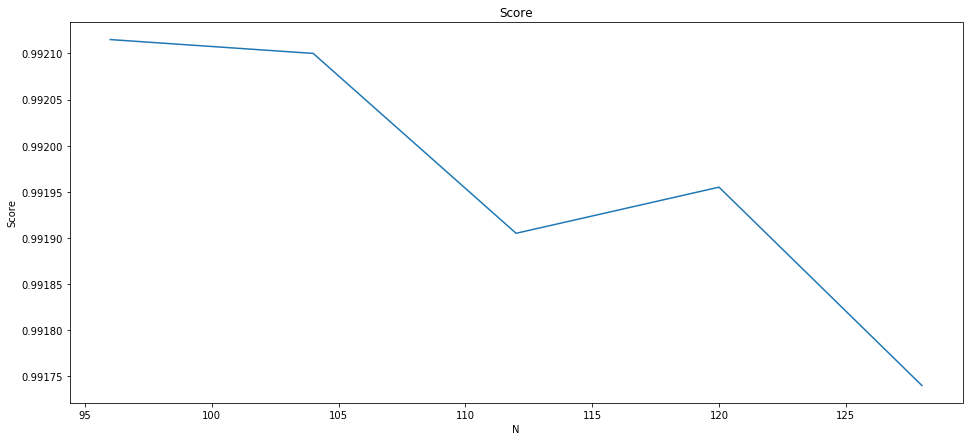

In [11]:
model = LinearSVC(max_iter=10000, random_state=6, verbose=5)
check_all_N(model, N_from=96)

Попробуем использовать деревья решений:

running with map for N=96
found cached data...

[[64957 35424]
 [40917 58702]]
0.618295
113.341505
running with map for N=104
found cached data...

[[51196 35384]
 [41673 71747]]
0.614715
123.251734
running with map for N=112
found cached data...

[[57946 36278]
 [42746 63030]]
0.60488
136.628745
running with map for N=120
found cached data...

[[57409 36368]
 [42801 63422]]
0.604155
147.666415
running with map for N=128
found cached data...

[[41373 35407]
 [42602 80618]]
0.609955
157.755447


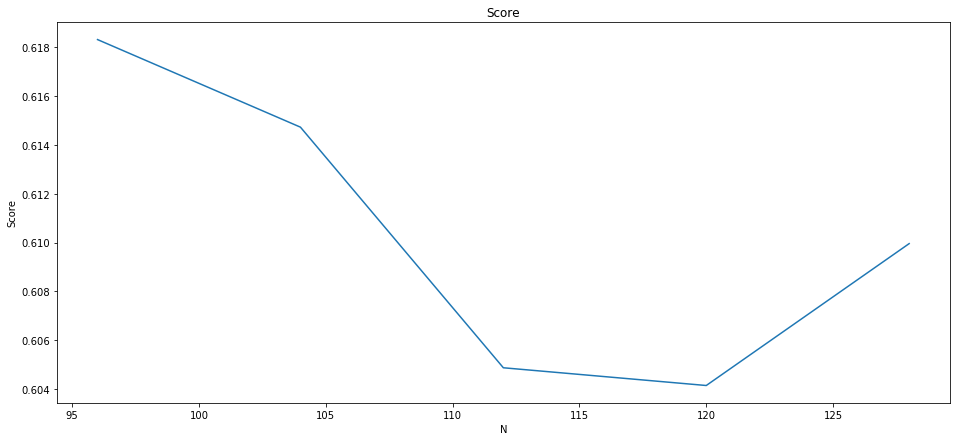

In [12]:
model = DecisionTreeClassifier(min_samples_leaf=4)
check_all_N(model, N_from=96)

In [13]:
def try_subset(X, y, model, percentage):
    part = int(X.shape[0] * percentage / 100.0)
    return learn(X.loc[:part, :], y.loc[:part], model)

In [14]:
def find_part(model, N, thr=0.95, step=10):
    X, y = read_base(N, try_map)
    for pt in np.arange(0.1, 95, step):
        print 'running for', pt
        acc = try_subset(X, y, model, pt)
        if acc >= thr:
            print 'Need', pt, '% data to achieve', thr
            break
    return pt

In [15]:
model = LogisticRegression(n_jobs=-1, random_state=6)
find_part(model, 128)

found cached data...
running for 0.1

[[ 45  27]
 [ 15 114]]
0.791044776119
running for 10.1

[[ 7664   137]
 [  136 12264]]
0.986485817534
Need 10.1 % data to achieve 0.95


10.1

In [16]:
model = LogisticRegression(n_jobs=-1, random_state=6)
find_part(model, 128, step=0.1)

found cached data...
running for 0.1

[[ 45  27]
 [ 15 114]]
0.791044776119
running for 0.2

[[125  23]
 [ 26 227]]
0.877805486284
running for 0.3

[[188  34]
 [ 33 346]]
0.888519134775
running for 0.4

[[260  29]
 [ 38 474]]
0.916354556804
running for 0.5

[[347  28]
 [ 33 593]]
0.939060939061
running for 0.6

[[393  31]
 [ 34 743]]
0.945878434638
running for 0.7

[[463  44]
 [ 31 863]]
0.946466809422
running for 0.8

[[564  42]
 [ 42 953]]
0.947532792005
running for 0.9

[[ 639   38]
 [  43 1081]]
0.955024986119
Need 0.9 % data to achieve 0.95


0.90000000000000002

Попробуем запустить логистическую регрессию на 128-битном входе с используемой ранее трансформацией входа, но при этом **не учитывая первые 128 характеристик**, то есть оставив лишь искусственные ксоры:

In [19]:
def map_without_initial(x):
    all_xor = reduce(lambda kum, v: kum ^ int(v), x, 0)
    res = []
    res.append(all_xor)
    cur_xor = all_xor
    for i in x:
        cur_xor ^= int(i)
        res.append(cur_xor)
    cur_xor = 0
    for i in x:
        cur_xor ^= int(i)
        res.append(cur_xor)
    return res

model = LogisticRegression(n_jobs=-1, random_state=6)
X, y = read_base(128, map_without_initial)
print 'finished reading input...'
print learn(X, y, model)

found cached data...
finished reading input...

[[ 75917    863]
 [   838 122382]]
0.991495
0.991495


Как видно, результат по-прежнему хорош

# Выводы

В качестве метрики хорошо показывает себя предложенная метрика **Accuracy** (поскольку классификация бинарная). Кроме того, полезно оценить матрицу ошибок, потому что без изменения входа *LogisticRegression* начиная с некоторого *N* везде предсказывала либо чистый *0*, либо чистый *1* (в этом отчете этого не осталось). Это можно было увидеть по матрице ошибок: одна из колонок была полностью нулевая.

Зависимости метрики **Accuracy** от *N* представлены на графиках. Среди реально запущенных классификаторов (*LogisticRegression*, *LinearSVC*, *DecisionTree*) только *DecisionTree* не смогло приблизиться к результатам первых двух и осталось на уровне обычного логистической регрессии на чистом входе. Скорее всего, это обусловлено тем, что деревья решений хорошо работают со значениями характеристик на интервалах, а здесь значение каждой характеристики бинарно. Это ведет к достаточно глубокому дереву, что, вероятнее всего, ведет к переобучению. 

*KNN* выполнялся слишком долго, так что пришлось его остановить.

Как видно из последних запусков $\approx 0.1\%$ данных достаточно, чтобы получить 0.95 accuracy.